<a href="https://colab.research.google.com/github/itoshiyanazawa/rnn_project/blob/main/test_Itoshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install visualkeras

In [2]:
import urllib.request
import zipfile
import os
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt
import visualkeras
from sklearn.model_selection import train_test_split

In [3]:
# Establish GPU runtime for faster development
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Step 1

1. Collect the text dataset:
  *   Download the text dataset from a reputable source or use a pre-existing one.

2. Clean the text data:
  *   Remove unwanted characters, punctuation, and formatting.
  *  Convert all text to lowercase to reduce complexity.

3. Tokenize the text:
  *   Split the text into individual characters.
  *   Create a vocabulary of unique tokens and map each token to an integer.

4. Create input sequences:
  *   Generate input sequences and corresponding targets for training.



Collecting the Movie Dialogues dataset from the Cornell University Website

In [4]:
# --- Step 1: Data Collection and Preprocessing ---

# Download dataset
url = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
file_name = "cornell_movie_dialogs_corpus.zip"
urllib.request.urlretrieve(url, file_name)

# Extract dataset
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall("cornell_data")

# Read dialogues
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

# Extract and clean dialogue text
dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.,!?'\n ]+", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_dialogues = [clean_text(line) for line in dialogues]
full_text = ' '.join(cleaned_dialogues)
full_text = full_text[:1_000_000]  # cut to 1M characters for fast processing

Cleaning the Text Data

In [5]:
# --- Tokenization (Word Level) ---
# Split into words
words = full_text.split()

# Build word vocabulary
vocab = sorted(set(words))
word2idx = {w: idx for idx, w in enumerate(vocab)}
idx2word = {idx: w for w, idx in word2idx.items()}

# Convert full text into integer IDs
text_as_int = np.array([word2idx[w] for w in words])

vocab_size = len(vocab)
print(f"Vocabulary size (words): {vocab_size}")

# Show example sentence and its token

Vocabulary size (words): 21097


In [6]:
# --- Create Input Sequences and Targets ---
seq_length = 20  # 20 words input

word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Create sequences
sequences = word_dataset.window(seq_length+1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(seq_length+1))

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Shuffle and batch
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Train/Val/Test Split
dataset_size = dataset.cardinality().numpy()

train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Step 2

1. Define the RNN architecture (e.g. using Tensorflow or PyTorch).
2. Explain the type of layers you are including and why (layers such as Embedding, LSTM, and Linear)
3. Visualize your RNN architecture
4. Compile the model with appropriate loss function and optimizer. Explain your choice of loos function and optimizer.
5. Prepare data for training by converting sequences and targets into batches.
6. Train the model on the training data and validate it on the validation set.
7. Visualize the training process using both training and validation results.


Defining the RNN Architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 20, 128)        │     2,700,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20, 21097)      │     5,421,929 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,516,585 (32.49 MB)

 Trainable params: 8,516,585 (32.49 MB)

 Non-trainable params: 0 (0.00 B)

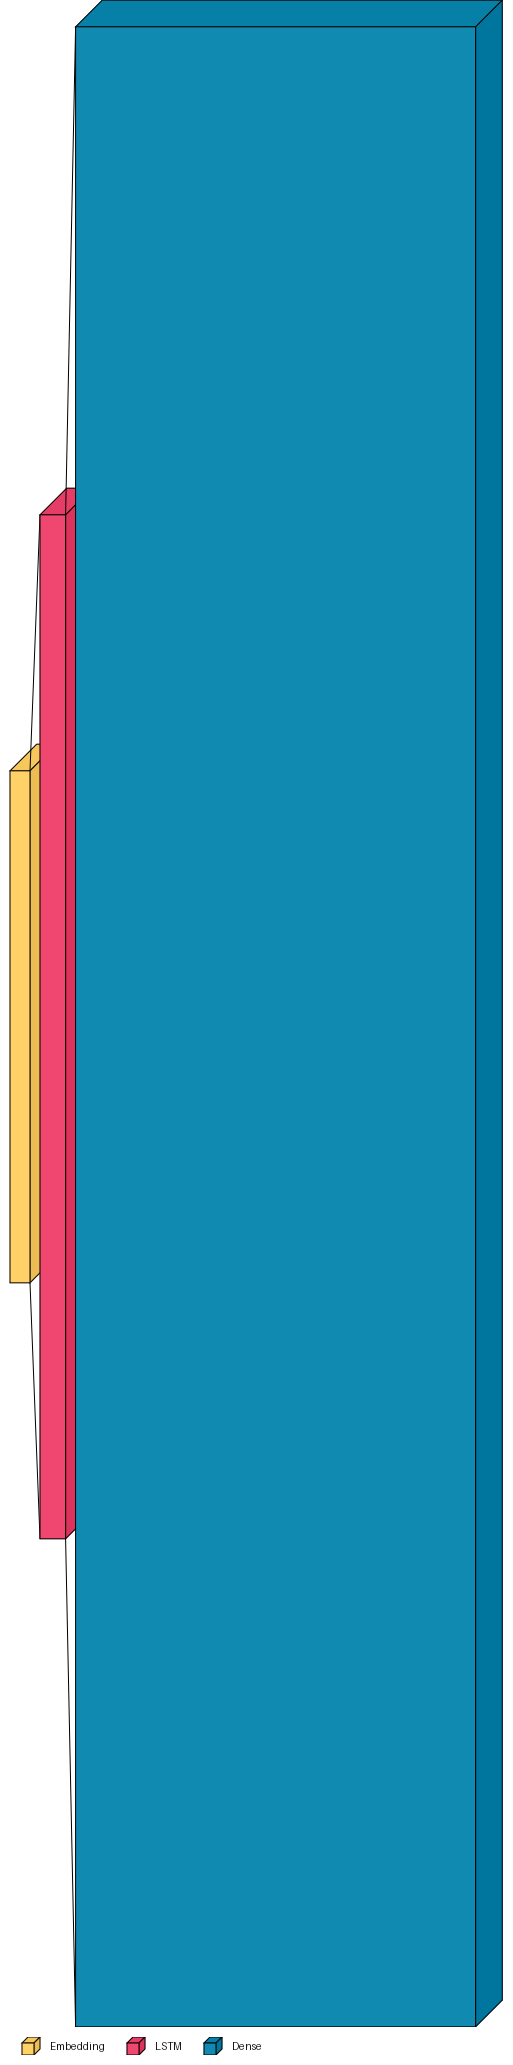

In [26]:
# --- Step 2: Build Basic RNN (Word Level Model) ---
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=seq_length),
    LSTM(256, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, seq_length))
model.summary()
visualkeras.layered_view(model, legend=True)

**Layer Breakdown**:
- `Embedding`: Converts integer indices into dense 64-dimensional vectors. This helps the model learn semantic relationships between characters.
- `LSTM`: Long Short-Term Memory layer with 128 units, captures temporal dependencies and handles vanishing gradient issues better than simple RNNs.
- `Dense`: Fully connected output layer with `softmax` activation, outputs probabilities across the vocabulary to predict the next character.


Compiling the model with appropriate loss function and optimizer.
**Loss Function**:
- We use `sparse_categorical_crossentropy` because the target output is a single integer (not one-hot encoded).

**Optimizer**:
- `Adam` is used for its adaptive learning rate, helping the model converge faster and more reliably during training.


In [28]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size = 128
)

Epoch 1/20
2951/2951 ━━━━━━━━━━━━━━━━━━━━ 214s 73ms/step - accuracy: 0.3732 - loss: 3.2869
Epoch 2/20
   2/2951 ━━━━━━━━━━━━━━━━━━━━ 3:32 72ms/step - accuracy: 0.2129 - loss: 4.5355

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2951/2951 ━━━━━━━━━━━━━━━━━━━━ 214s 73ms/step - accuracy: 0.4919 - loss: 2.5416
Epoch 3/20
2951/2951 ━━━━━━━━━━━━━━━━━━━━ 214s 73ms/step - accuracy: 0.5816 - loss: 2.0394
Epoch 4/20
2951/2951 ━━━━━━━━━━━━━━━━━━━━ 215s 73ms/step - accuracy: 0.6504 - loss: 1.6800
Epoch 5/20
2951/2951 ━━━━━━━━━━━━━━━━━━━━ 262s 73ms/step - accuracy: 0.7038 - loss: 1.4135
Epoch 6/20


KeyboardInterrupt: 

Step 2 Summary

- The RNN uses an Embedding layer to learn dense vector representations of characters.
- An LSTM layer with 128 units captures temporal dependencies in character sequences.
- A Dense layer with `softmax` outputs the probability distribution over the vocabulary.

Compiled with `sparse_categorical_crossentropy` and `adam`, the model learns to predict the next character in a sequence.


# Step 3

1. Create a function to generate text by sampling from the model's predictions.

Qualitative Evaluation:

2. Coherence and Grammar: Check if the generated text is grammatically correct and coherent.

3. Creativity: Evaluate if the generated text is creative and interesting.

4. Contextual Relevance: Assess whether the generated text maintains context and follows logically from the seed text.

5. Diversity: Ensure that the model does not repeat itself excessively and generates diverse outputs.

Quantitative Evaluation:

6. Perplexity: A common metric for evaluating language models. Perplexity measures how well the model predicts the next token in a sequence. Lower perplexity indicates better performance.

7. BLEU Score: Used to evaluate the quality of text that has been machine-translated from one language to another. It can be adapted to measure the overlap between generated text and reference text.

8. ROUGE Score: Commonly used for evaluating summarization and translation models. It measures the overlap of n-grams between the generated text and a reference text.

9. Entropy and Repetition Metrics: Measure the diversity of the generated text. High entropy and low repetition indicate diverse and less repetitive outputs.




# Step 4

1. Experiment with different architectures (e.g., adding more layers, or trying other layer types).
 * Try deeper networks, different activation functions, or different layer configurations.
 * Example: Adding more LSTM layers or using GRU instead of LSTM.
2. Apply regularization techniques (e.g., Use dropout to prevent overfitting).
3. Use advanced text preprocessing.
 * Implement techniques like stemming, lemmatization, or BPE (Byte Pair Encoding) for
better tokenization.
4. Fine-tune hyperparameters (e.g., learning rate, batch size).
 * Experiment with different learning rates, batch sizes, and epochs.
 * Explain your approach for fine-tuning the hyper-parameters.